<b> HOMEWORK 3 - Nikunj Bhatia
    </b>

<b> Question 1
    </b>

In [77]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import sys
from scipy.io import loadmat
import time
%matplotlib inline

In [78]:
def l2distance(X, Z=None):
    if Z is None:
        n, d = X.shape
        x1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        D1 = -2 * np.dot(X, X.T) + repmat(x1, 1, n)
        D = D1 + repmat(x1.T, n, 1)
        np.fill_diagonal(D, 0)
        D = np.sqrt(np.maximum(D, 0))
    else:
        n, d = X.shape
        m, empty = Z.shape
        x1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        x2 = np.sum(np.power(Z, 2), axis=1).reshape(1,-1)
        D1 = -2 * np.dot(X, Z.T) + repmat(x1, 1, m)
        D = D1 + repmat(x2, n, 1)
        D = np.sqrt(np.maximum(D, 0))
    return D

In [79]:
def toydata(OFFSET,N):
    x = np.random.randn(N, 2)
    x[N//2:, :] += OFFSET  
    y = np.ones(N)
    y[N//2:] *= 2
    nw = np.random.permutation(N)
    return x[nw, :], y[nw]

In [80]:
def computeybar(xTe, OFFSET):
    n,temp = xTe.shape
    ybar = np.zeros(n)
    normpdf = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)
    for i in range(n):
        py1_=np.prod(normpdf(xTe[i],0,1))*0.5
        py2_=np.prod(normpdf(xTe[i],OFFSET,1))*0.5
        py1=py1_/(py1_+py2_)
        py2=py2_/(py1_+py2_)
        ybar[i]=1*py1+2*py2
    return ybar

Error is  8.1 %


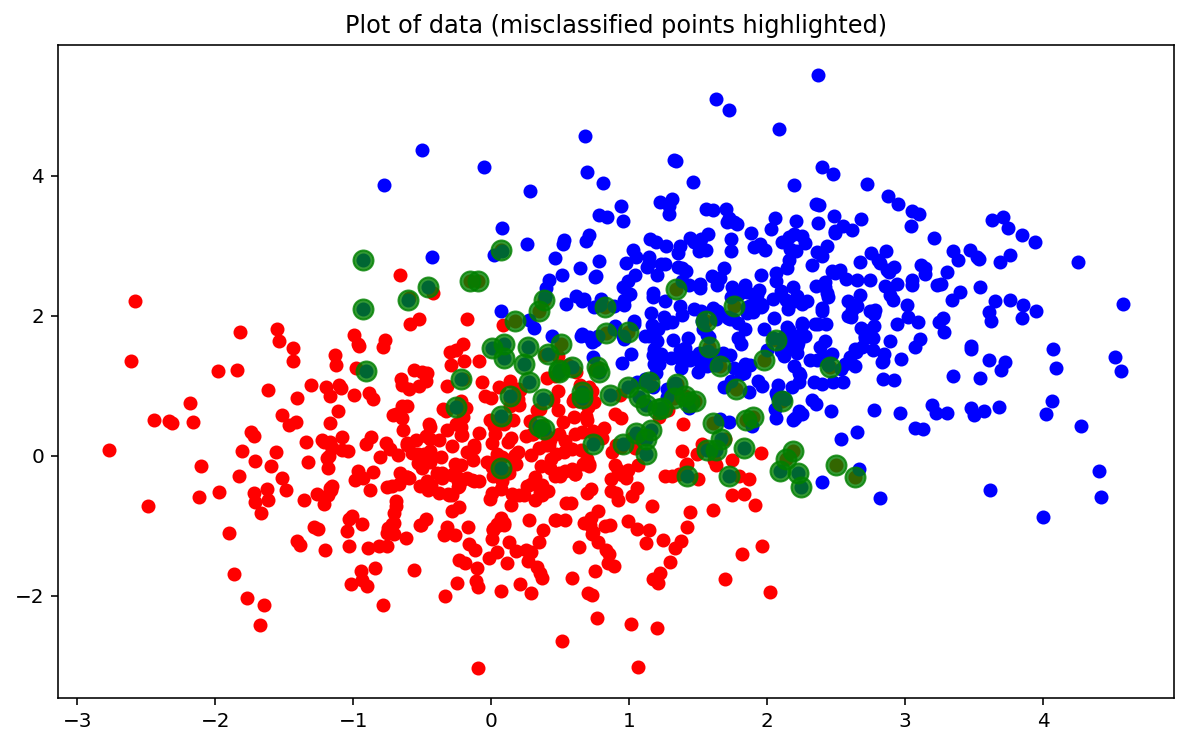

In [144]:
OFFSET = 2
numb = 1000
xTe, yTe = toydata(OFFSET, numb)

ybar = computeybar(xTe, OFFSET)
predictions = np.round(ybar)
errors = predictions != yTe
err = errors.sum() / len(yTe) * 100
print('Error is ', round(err,3),"%")

i1 = yTe == 1
i2 = yTe == 2
plt.figure(figsize=(10,6))
plt.scatter(xTe[i1, 0], xTe[i1, 1], c='r', marker='o')
plt.scatter(xTe[i2, 0], xTe[i2, 1], c='b', marker='o')
plt.scatter(xTe[errors, 0], xTe[errors, 1], c='g', s=100, alpha=0.8)
plt.title("Plot of data (misclassified points highlighted)")
plt.show()

In [82]:
def kregression(xTr,yTr,sigma=0.1,lmbda=0.01):
    kernel = lambda x, z: np.power(1+(np.power(l2distance(x,z),2) / (2 * np.power(sigma,2))),-4)
    ridge = lambda K, lmbda2: K + lmbda * np.eye(K.shape[0], K.shape[1])
    beta = np.linalg.solve(ridge(kernel(xTr, xTr), lmbda), yTr)
    fun = lambda Xt: np.dot(kernel(Xt, xTr), beta)
    return fun

In [83]:
def computehbar(xTe, sigma, lmbda, Nsmall, NMODELS, OFFSET):
    n = xTe.shape[0]
    hbar = np.zeros(n)
    for j in range(NMODELS):
        xTr, yTr = toydata(OFFSET, Nsmall)
        fun = kregression(xTr, yTr, sigma, lmbda)
        hbar += fun(xTe)
    hbar /= NMODELS
    return hbar

In [84]:
def computevariance(xTe, sigma, lmbda, hbar, Nsmall, NMODELS, OFFSET):
    n = xTe.shape[0]
    variance = np.zeros(n)
    for j in range(NMODELS):
        xTr, yTr = toydata(OFFSET, Nsmall)
        fun = kregression(xTr, yTr, sigma, lmbda)
        pred = fun(xTe)
        diffSqr = (pred - hbar)**2
        variance += diffSqr
    variance = np.mean(variance)/NMODELS
    return variance

In [85]:
Nsmall = 10
Nbig = 10000
NMODELS = 100
lmbdas = np.arange(-6, 0+0.5, 0.5)
sigma = 4

Nlambdas = len(lmbdas)
lbias = np.zeros(Nlambdas)
lvariance = np.zeros(Nlambdas)
ltotal = np.zeros(Nlambdas)
lnoise = np.zeros(Nlambdas)
lsum = np.zeros(Nlambdas)

for md in range(Nlambdas):
    lmbda = 2 ** lmbdas[md]
    
    xTe,yTe = toydata(OFFSET,Nbig)
    
    total = 0
    for j in range(NMODELS):
        xTr2,yTr2 = toydata(OFFSET,Nsmall)
        fsmall = kregression(xTr2,yTr2,sigma,lmbda)
        total += np.mean((fsmall(xTe) - yTe) ** 2)
    total /= NMODELS
    
    ybar = computeybar(xTe, OFFSET)
    noise = np.mean((yTe-ybar) ** 2)
    
    hbar = computehbar(xTe,sigma, lmbda, Nsmall, NMODELS, OFFSET)
    bias = np.mean((hbar-ybar) ** 2)
    
    variance = computevariance(xTe,sigma,lmbda,hbar, Nsmall, NMODELS, OFFSET)
    
    lbias[md] = bias
    lvariance[md] = variance
    ltotal[md] = total
    lnoise[md] = noise
    lsum[md] = lbias[md]+lvariance[md]+lnoise[md]
    print('Regularization λ=2^%2.1f: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (lmbdas[md],lbias[md],lvariance[md],lnoise[md],lsum[md],ltotal[md]))

Regularization λ=2^-6.0: Bias: 0.0268 Variance: 0.0897 Noise: 0.0576 Bias+Variance+Noise: 0.1741 Test error: 0.1662
Regularization λ=2^-5.5: Bias: 0.0256 Variance: 0.0606 Noise: 0.0583 Bias+Variance+Noise: 0.1445 Test error: 0.1435
Regularization λ=2^-5.0: Bias: 0.0292 Variance: 0.0520 Noise: 0.0552 Bias+Variance+Noise: 0.1364 Test error: 0.1508
Regularization λ=2^-4.5: Bias: 0.0291 Variance: 0.0595 Noise: 0.0578 Bias+Variance+Noise: 0.1465 Test error: 0.1399
Regularization λ=2^-4.0: Bias: 0.0402 Variance: 0.0489 Noise: 0.0578 Bias+Variance+Noise: 0.1468 Test error: 0.1483
Regularization λ=2^-3.5: Bias: 0.0389 Variance: 0.0459 Noise: 0.0604 Bias+Variance+Noise: 0.1452 Test error: 0.1397
Regularization λ=2^-3.0: Bias: 0.0520 Variance: 0.0372 Noise: 0.0583 Bias+Variance+Noise: 0.1475 Test error: 0.1541
Regularization λ=2^-2.5: Bias: 0.0526 Variance: 0.0364 Noise: 0.0594 Bias+Variance+Noise: 0.1484 Test error: 0.1478
Regularization λ=2^-2.0: Bias: 0.0668 Variance: 0.0281 Noise: 0.0567 Bia

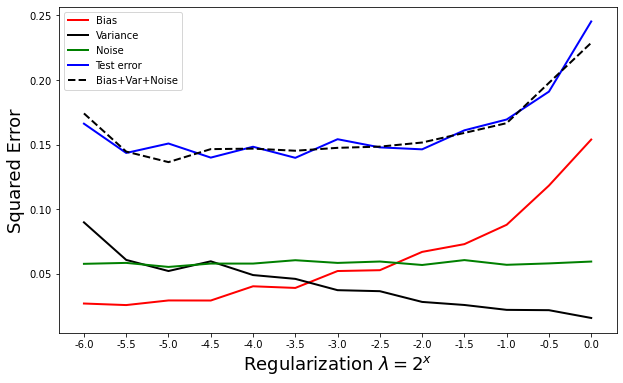

In [86]:
# plot results
plt.figure(figsize=(10,6))
plt.plot(lbias[:Nlambdas],c='r',linestyle='-',linewidth=2)
plt.plot(lvariance[:Nlambdas],c='k', linestyle='-',linewidth=2)
plt.plot(lnoise[:Nlambdas],c='g', linestyle='-',linewidth=2)
plt.plot(ltotal[:Nlambdas],c='b', linestyle='-',linewidth=2)
plt.plot(lsum[:Nlambdas],c='k', linestyle='--',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"]);
plt.xlabel("Regularization $\lambda=2^x$",fontsize=18);
plt.ylabel("Squared Error",fontsize=18);
plt.xticks([i for i in range(Nlambdas)],lmbdas);

<b>QUESTION 2</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df=pd.read_table('hw3_data2.txt',header=None,sep=',',names=['sign','X','Y'])

In [57]:
df.head()

,sign,X,Y
0,+,1.607874,9.247557
1,+,3.003258,6.610258
2,+,4.069008,18.327280
3,+,0.407198,14.835517
4,+,13.747305,8.219991


In [58]:
df1=df.loc[df['sign']=='+']
df2=df.loc[df['sign']=='-']

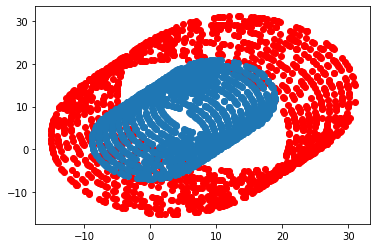

In [59]:
plt.scatter(x=df2['X'],y=df2['Y'],c='r')
plt.scatter(x=df1['X'],y=df1['Y'])

In [60]:
df.describe()

,X,Y
count,3600.000000,3600.000000
mean,6.304302,7.505592
std,10.429066,10.091645
min,-15.089255,-15.085650
25%,-2.045961,0.122646
50%,5.992859,7.358604
75%,13.593154,14.841659
max,30.996093,31.089476


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sign    3600 non-null   object 
 1   X       3600 non-null   float64
 2   Y       3600 non-null   float64
dtypes: float64(2), object(1)
memory usage: 84.5+ KB


In [62]:
df.sign.unique()

array(['+', '-'], dtype=object)

In [63]:
df[df['sign']=='+'].X

0        1.607874
1        3.003258
2        4.069008
3        0.407198
4       13.747305
          ...    
1995    11.228495
1996     0.237604
1997    -1.134430
1998     1.101835
1999    -4.144323
Name: X, Length: 2000, dtype: float64

In [64]:
df[df['sign']=='-'].Y

2000    -5.706479
2001    23.223937
2002    -4.938801
2003    -1.847031
2004    -0.755544
          ...    
3595   -12.911918
3596    14.745135
3597    -5.554782
3598    31.081189
3599   -11.137102
Name: Y, Length: 1600, dtype: float64

In [65]:
import random as rnd

In [66]:
def Create_Matrix():
    
    pos_x = np.array(df.X)
    #pos_y = np.array(df[df['sign']=='+'].Y)
    neg_x = np.array(df.Y)
    #neg_y = np.array(df[df['sign']=='+'].Y)

    global sign_matrix
    sign_matrix =  np.column_stack((pos_x,neg_x))
    

In [67]:
class SVM():
    
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'rbf':self.kernel_rbf,
            'quadratic' : self.kernel_quadratic
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        # n : number of samples (100)
        n = X.shape[0]
        
        #we have alpha per sample of training set. Initially set to zeros
        alpha = np.zeros((n))
        
        #pick the kernel user selected
        kernel = self.kernels[self.kernel_type]
        
        
        iteration = 0
        while True:
            iteration += 1
            
            #saving the copy of alpha from previous iteration
            alpha_prev = np.copy(alpha)
            
            #going through all the samples in one iteration
            for j in range(0, n):
                
                #selcting random sample index where i is not equal to j
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                
                x_i = X[i,:]
                x_j = X[j,:]
                y_i = y[i]
                y_j = y[j]
                
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                
                if k_ij == 0:
                    continue
                
                #select alpha of i and j from the alpha array to calculate L and H
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Terminating condition: reacing convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            #Terminating condition: Reaching max iterationsac
            if iteration >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
            
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
            print('Linear Running')
            
            
    def predict(self, X):
        return self.h(X, self.w, self.b)
    
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    
    def calc_w(self, alpha, y, X):
        return np.dot(alpha * y, X)
    
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
        
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_rbf(self,x1,x2):
        return (np.exp(-1*np.sum((x2-x1[:,np.newaxis])**2,axis=-1)))
    
    #Printing out the parameters of SVM
    def print_info(self):
        print("############ PRINT SVM INFO ################")
        print("C:",self.C)
        print("max_iter:",self.max_iter)
        print("epsilon:",self.epsilon)
        print("kernel_type:",self.kernel_type)




In [68]:
################################################################################
def calc_acc(y, y_hat):
    
    correct_counter = 0
    for i in range(0,len(y)):
        if(y[i] == -1 and y_hat[i] == -1):
            correct_counter = correct_counter + 1
        if(y[i] == 1 and y_hat[i] == 1):
            correct_counter = correct_counter + 1
    
    return (correct_counter/len(y))
    

In [69]:
def compute_RBF(mat1, mat2, sigma):

    trnorms1 = np.mat([(v * v.T)[0, 0] for v in mat1]).T
    trnorms2 = np.mat([(v * v.T)[0, 0] for v in mat2]).T

    k1 = trnorms1 * np.mat(np.ones((mat2.shape[0], 1), dtype=np.float64)).T

    k2 = np.mat(np.ones((mat1.shape[0], 1), dtype=np.float64)) * trnorms2.T

    k = k1 + k2

    k -= 2 * np.mat(mat1 * mat2.T)

    k *= - 1./(2 * np.power(sigma, 2))

    return np.exp(k)

In [70]:
################################################################################
def main():
    
    
    
    Create_Matrix()
    
    C = 1
    max_iter = 1000
    epsilon = 0.001
    kernel_type = 'linear'
    Y_sign=[]
    model = SVM(max_iter,kernel_type,C,epsilon)
    sign_type = 0
    l1=df.sign.values.tolist()
    for i in l1:
        if(i == '+'):
            sign_type = 1
        if(i == '-'):
            sign_type = -1
        Y_sign.append(sign_type)
    
    
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(sign_matrix, Y_sign, test_size = 0.2, random_state = 0)
    
    global support_vectors

    model.fit(X_train,y_train)

    # Make prediction
    y_hat = model.predict(X_test)

    # Calculate accuracy
    accuracy = calc_acc(y_test, y_hat)
    
    model.print_info()
    print("\nAccuracy:",accuracy)

    for i in range(0,len(y_train)):
        if(y_train[i] == 1):
            plt.plot(X_train[i,0],X_train[i,1],'r*')
        else:
            plt.plot(X_train[i,0],X_train[i,1],'b*')
    plt.title("Training Set")

    plt.show()
    
    
    for i in range(0,len(y_hat)):
        if(y_hat[i] == 1):
            plt.plot(X_test[i,0],X_test[i,1],'r*')
        else:
            plt.plot(X_test[i,0],X_test[i,1],'b*')
    plt.title("Test Set Result")

    plt.show()


Linear Running
############ PRINT SVM INFO ################
C: 1
max_iter: 1000
epsilon: 0.001
kernel_type: linear

Accuracy: 0.5416666666666666


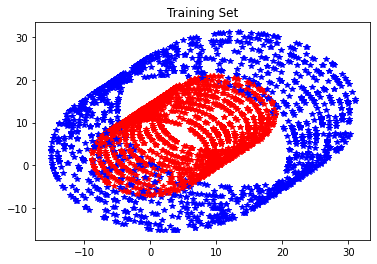

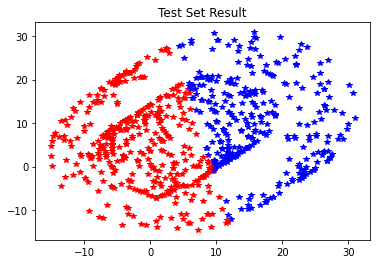

In [71]:
main()

In [75]:
################################################################################
def main():
    
    
    
    Create_Matrix()
    
    C = 1
    max_iter = 1000
    epsilon = 0.001
    kernel_type = 'quadratic'
    Y_sign=[]
    model = SVM(max_iter,kernel_type,C,epsilon)
    sign_type = 0
    l1=df.sign.values.tolist()
    for i in l1:
        if(i == '+'):
            sign_type = 1
        if(i == '-'):
            sign_type = -1
        Y_sign.append(sign_type)
    
    
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(sign_matrix, Y_sign, test_size = 0.2, random_state = 0)
    
    global support_vectors

    model.fit(X_train,y_train)

    # Make prediction
    y_hat = model.predict(X_test)

    # Calculate accuracy
    accuracy = calc_acc(y_test, y_hat)
    
    model.print_info()
    print("\nAccuracy:",accuracy)

    for i in range(0,len(y_train)):
        if(y_train[i] == 1):
            plt.plot(X_train[i,0],X_train[i,1],'r*')
        else:
            plt.plot(X_train[i,0],X_train[i,1],'b*')
    plt.title("Training Set")

    plt.show()
    
    
    for i in range(0,len(y_hat)):
        if(y_hat[i] == 1):
            plt.plot(X_test[i,0],X_test[i,1],'r*')
        else:
            plt.plot(X_test[i,0],X_test[i,1],'b*')
    plt.title("Test Set Result")

    plt.show()


Iteration number exceeded the max of 1000 iterations
############ PRINT SVM INFO ################
C: 1
max_iter: 1000
epsilon: 0.001
kernel_type: quadratic

Accuracy: 0.4361111111111111


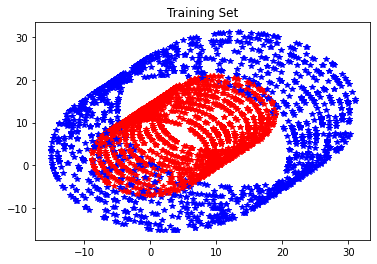

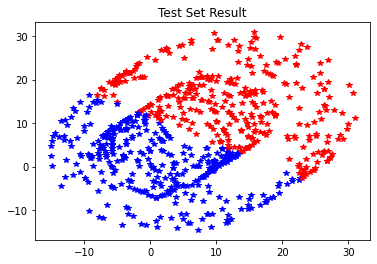

In [76]:
main()

<b> We will now try to find the accuracy by calling function for RBF
    </b>

In [103]:
X=df[['X','Y']]
y=df.sign

In [104]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


In [105]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC()

In [106]:
y_pred = svclassifier.predict(X_test)

In [107]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[410   5]
 [ 40 265]]
              precision    recall  f1-score   support

           +       0.91      0.99      0.95       415
           -       0.98      0.87      0.92       305

    accuracy                           0.94       720
   macro avg       0.95      0.93      0.93       720
weighted avg       0.94      0.94      0.94       720



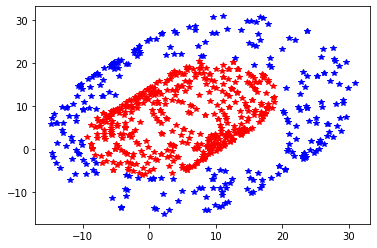

In [266]:
x_test_x = X_test['X'].values.tolist()
x_test_y = X_test['Y'].values.tolist()
for i in range(0,len(y_pred)):
    if(y_pred[i]=='+'):
        plt.plot(x_test_x[i],x_test_y[i],'r*')
    else:
        plt.plot(x_test_x[i],x_test_y[i],'b*')

The best classifier for this problem is rbf kernel SVM as the data we have is a multidimensinal data represented in 2D. RBF kernel increases the dimensionality and then finds the plane which separates the data. Thus it gives accuracy of over 94%. 
Other methods like linear and quadratic SVM don't give a good accuracy score as the data is non-linear. 

<b> Question 3
    </b>

a) part solution is hand written uploaded along with .ipynb and .py file as pdf

In [87]:
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor
import scipy.io
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [88]:
dset = pd.read_csv("conc.csv")

In [89]:
dset.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [109]:
dset.columns = ['cement' , 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate',
             'age', 'concrete_compressive_strength']

In [110]:
dset.shape

(1030, 9)

In [120]:
dset.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


<AxesSubplot:>

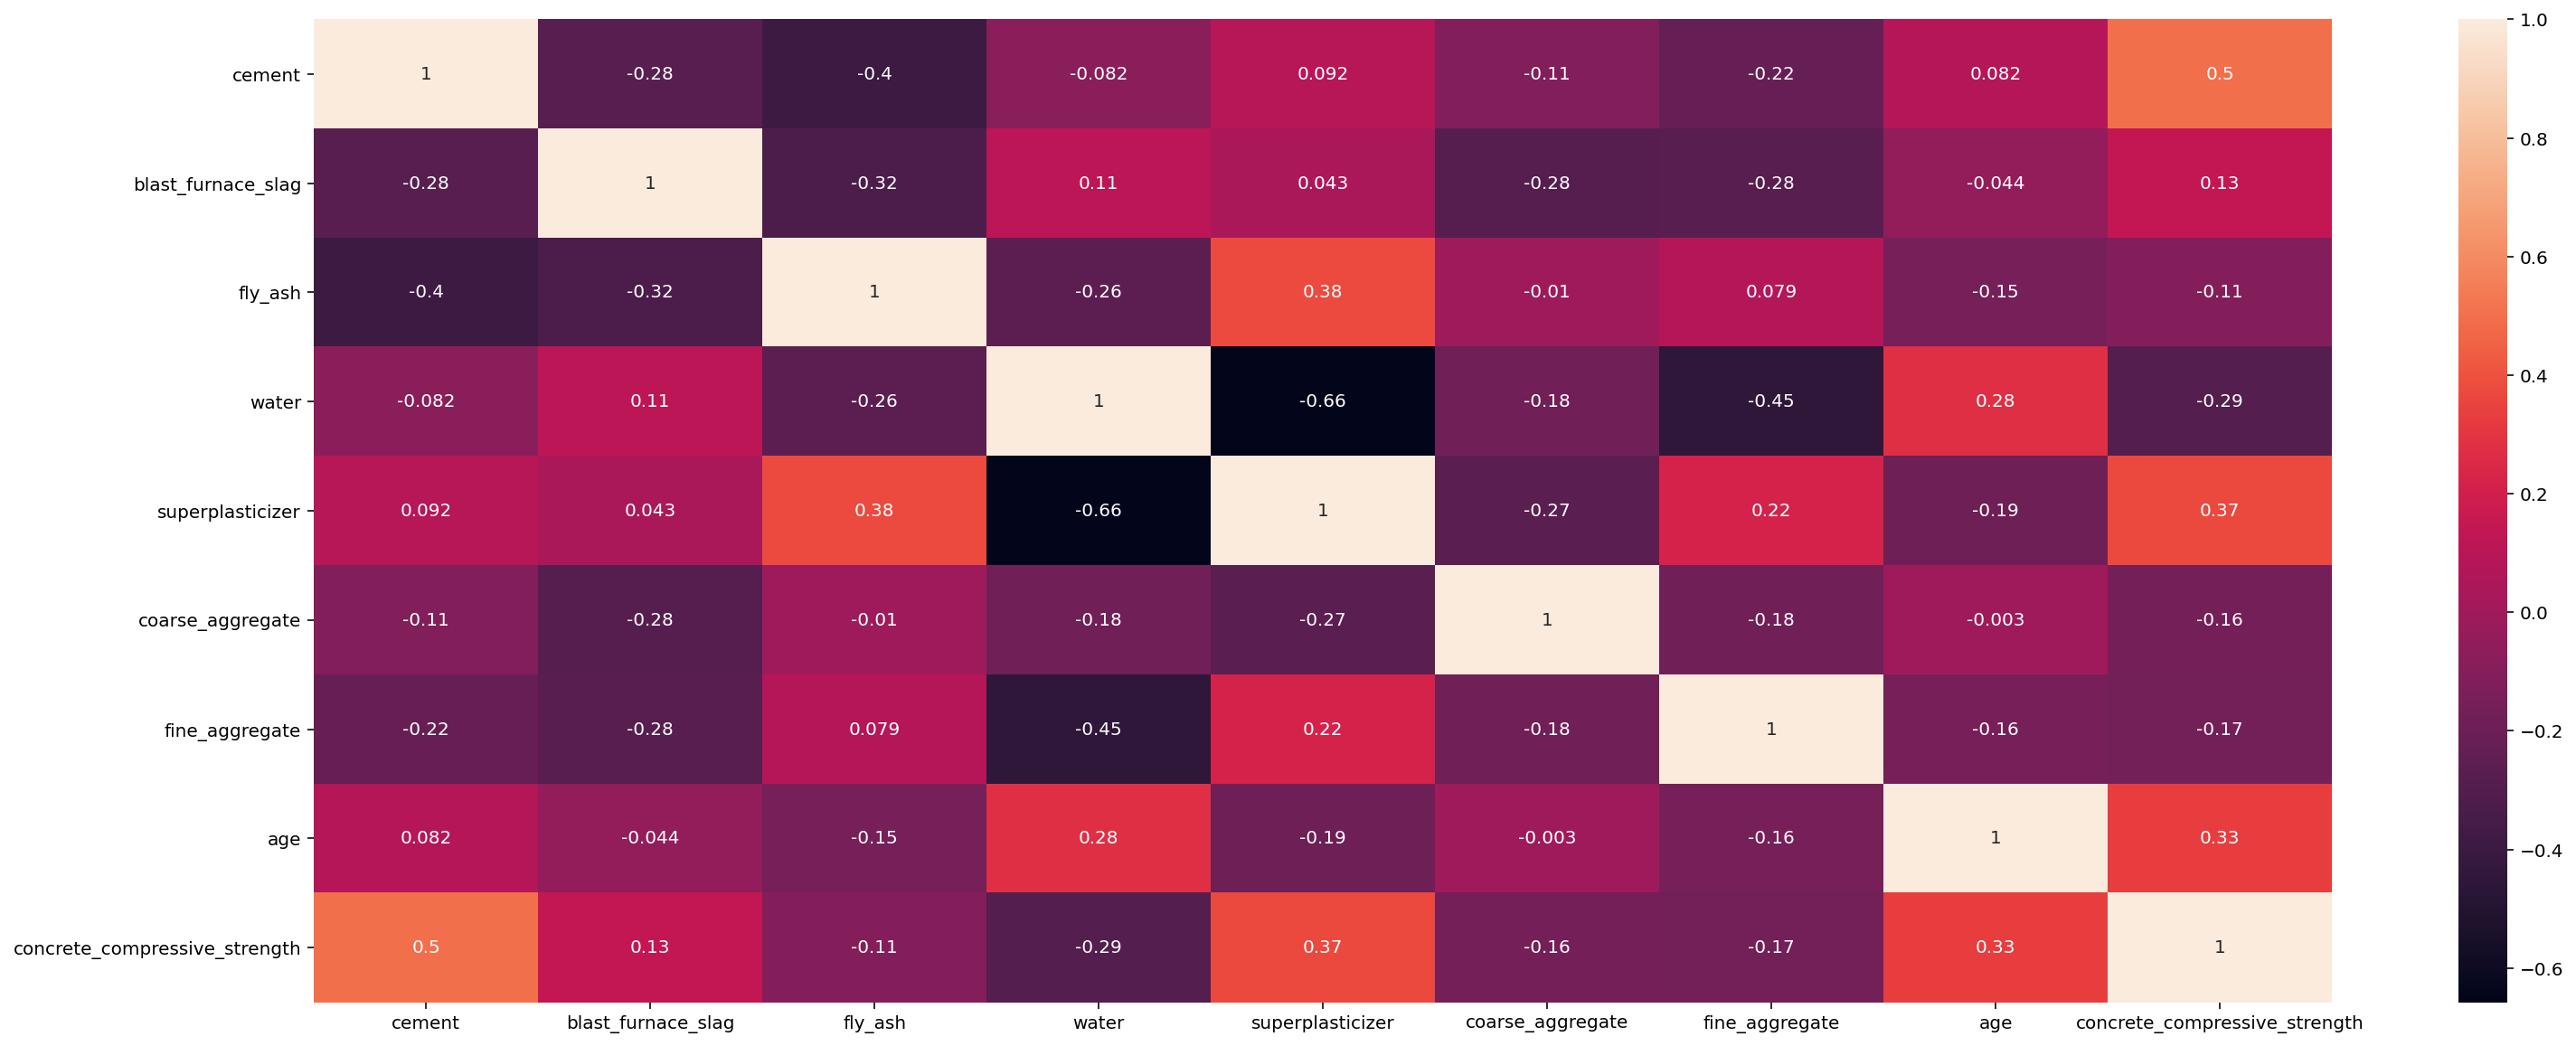

In [125]:
sns.heatmap(dset.corr(),annot=True)

In [111]:
dataset = dset.values

In [112]:
X = dataset[:,0:8]
Y = dataset[:,8]

In [113]:
X.shape

(1030, 8)

In [114]:
Y.shape

(1030,)

In [115]:
# first, define the prior
def phi(a):
    ell = 1.0
    return 3 * np.exp(-((a - np.linspace(-8, 8, 8).T) ** 2) / (ell ** 2) / 2.0)


F = len(phi(0))  # number of features
# set parameters of prior on the weights
mu = np.zeros((F, 1))
Sigma = np.eye(F)  # p(w)=N(mu,Sigma)

In [116]:
print(phi(0).shape)
print(phi(np.linspace(-8, 8, 100)[:, np.newaxis]).shape)

(8,)
(100, 8)


In [117]:
def m(x):
    return phi(x) @ mu


def k(a, b):
    return phi(a) @ Sigma @ phi(b).T

In [118]:
def GPRegression(m, k, X, Y):
    out = {}
    # construct implied prior on f_x
    n = 100  # number of grid-points, for plotting
    # reshape is needed for phi to work
    x = np.linspace(-8, 8, n)[:, np.newaxis]
    out["mx"] = m(x)
    out["kxx"] = k(x, x)  # p(f_x)=N(m,k_xx)
    out["s"] = multivariate_normal(m(x).flatten(), k(x, x), size=5).T
    # marginal stddev, for plotting
    out["stdpi"] = np.sqrt(np.diag(k(x, x)))[:, np.newaxis]

    X = X
    Y = Y
    sigma = 0.4  # measurement noise std-deviation [dummy variable, will tune later]
    N = len(X)  # number of data

    # evidence: p(Y) = N(Y;M,kXX + sigma**2 * no.eye(N))
    mX = m(X)
    kXX = k(X, X)  # p(f_X) = N(M,k_XX)
    G = kXX + sigma ** 2 * np.eye(N)

    # now, do inference (i.e. construct the posterior)
    # the following in-place decomposition is the most expensive step at O(N^3):
    G = cho_factor(G)
    kxX = k(x, X)  # Cov(f_x,f_X) = k_xX
    A = cho_solve(G, kxX.T).T  # pre-compute for re-use (but is only O(N^2))

    # # posterior p(f_x|Y) = N(f_x,mpost,vpost)
    out["mpost"] = m(x) + A @ (Y - mX)  # mean
    out["vpost"] = k(x, x) - A @ kxX.T  # covariance
    out["spost"] = multivariate_normal(
        out["mpost"].flatten(), out["vpost"], size=5
    ).T  # samples
    # marginal stddev, for plotting
    out["stdpo"] = np.sqrt(np.diag(out["vpost"]))[:, np.newaxis]

    return out

ValueError: mean and cov must have same length

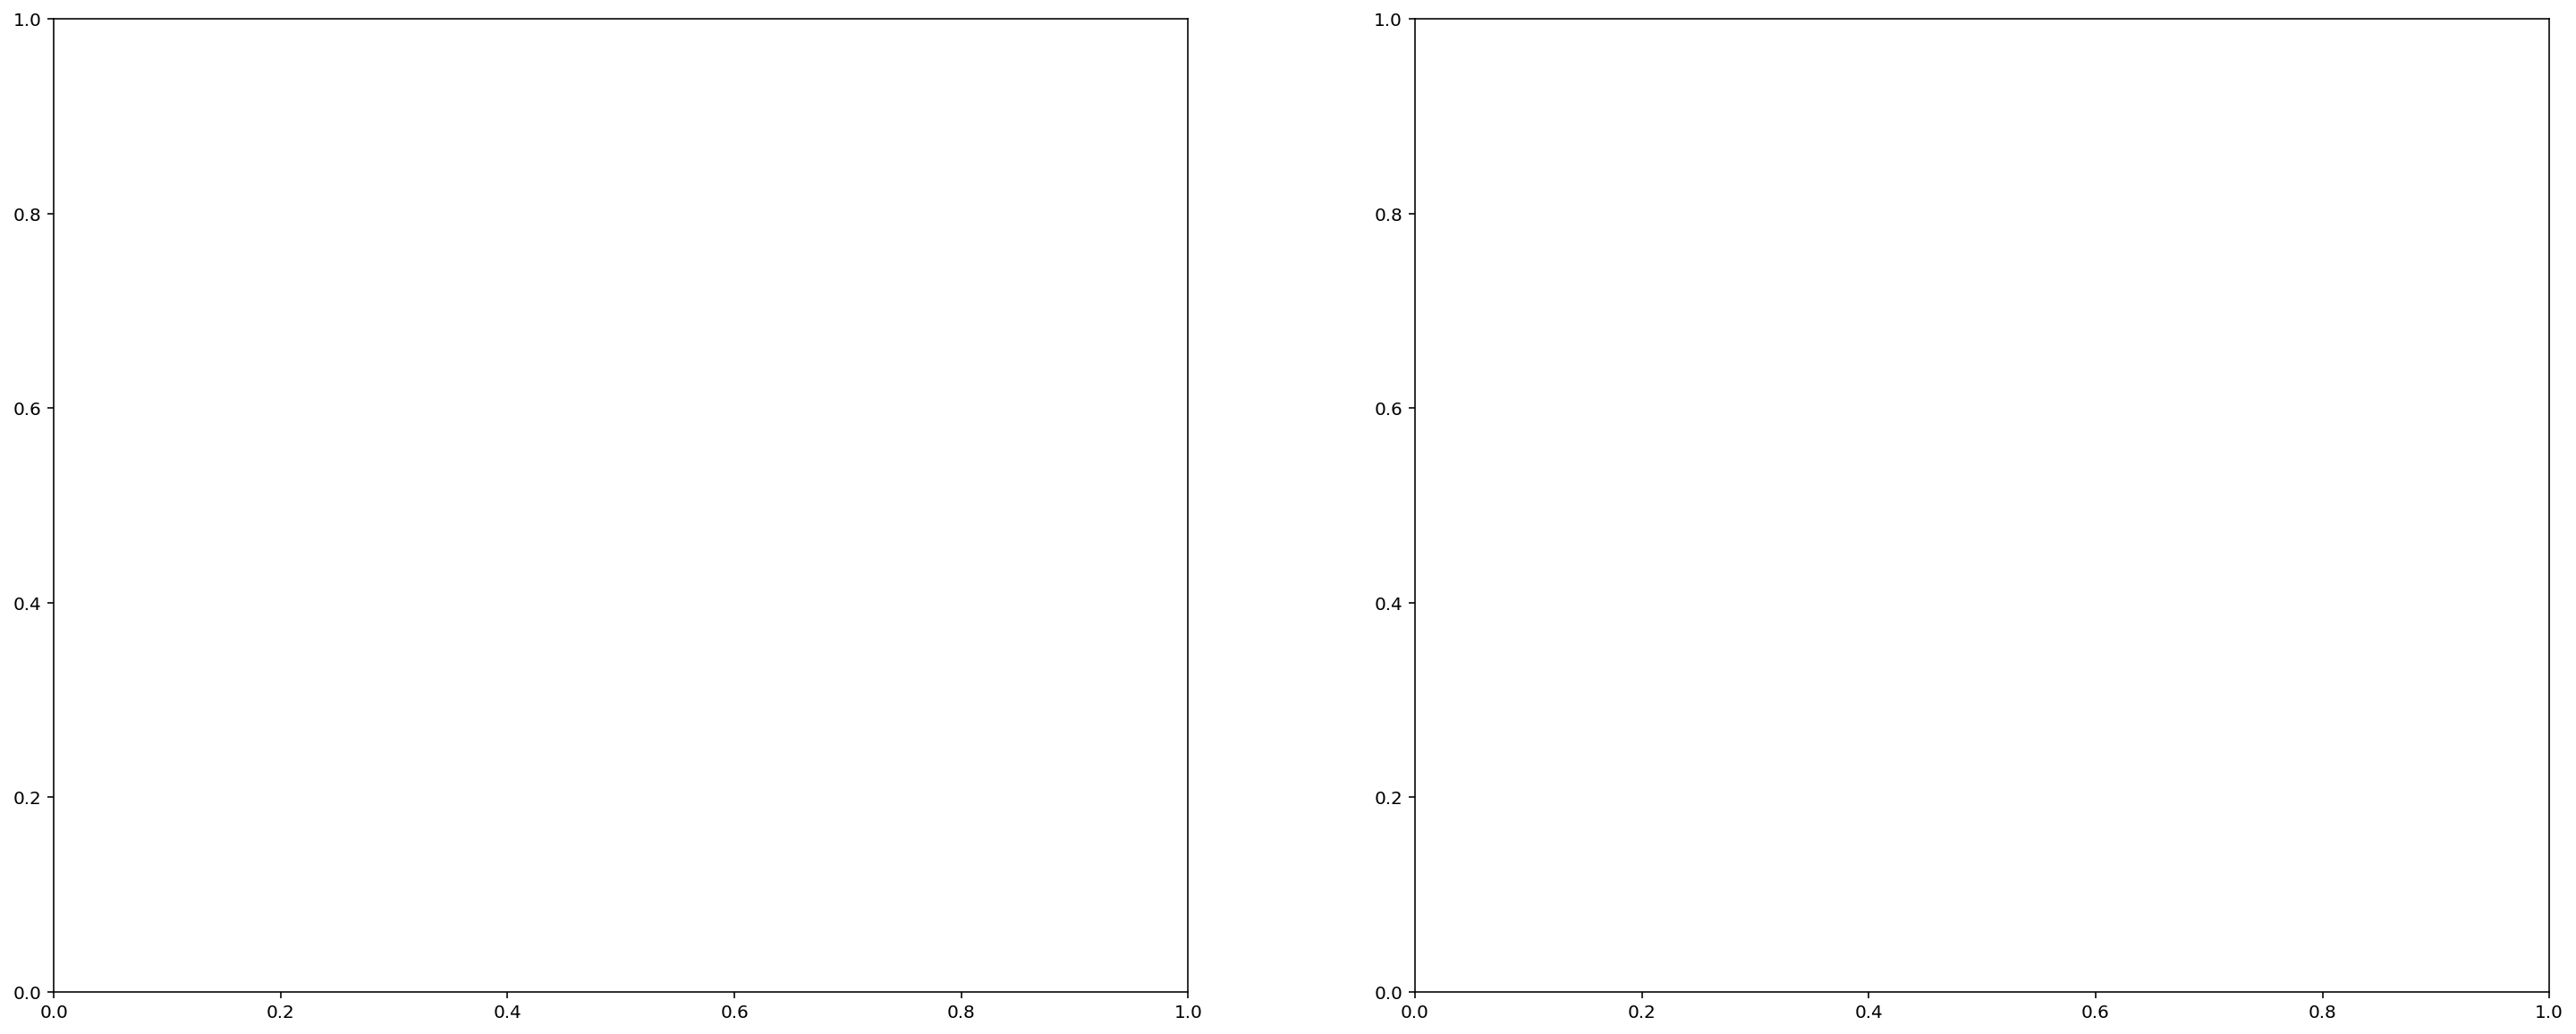

In [119]:
plt.rcParams["figure.figsize"] = (25, 10)
fig, ax = plt.subplots(1, 2)


def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


GPout = GPRegression(m, k, X , Y)

print(GPout)

Now I am going to call function and try to implement it.

In [131]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score 

In [127]:
X=dset.drop('concrete_compressive_strength',axis=1)
y=dset['concrete_compressive_strength']

In [128]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X) 

In [129]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=100)

In [132]:
ker = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [134]:
model = gp.GaussianProcessRegressor(kernel=ker, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [135]:
model.fit(X_train, y_train)
params = model.kernel_.get_params()

In [136]:
y_pred, std = model.predict(X_test, return_std=True)

In [138]:
error = ((y_pred-y_test)**2).mean()
error

32.86361721215399

In [139]:
r2_score(y_test,y_pred)

0.890391488562326

References :
https://github.com/aevanchen/machine_learning_miniprojects/blob/master/Bias%20Variance%20Tradeoff/python_HW5_BV.ipynb
https://aihubprojects.com/svm-from-scratch-python/

In Collaboration with :
Amatya Sonbhadra
Manu Singhal